# Transformer Encoder - Text Classification and Sentiment Analysis

### Connect to Colab

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/My Drive/Transformers

/gdrive/My Drive/Transformers


### Import libraries

In [3]:
import tensorflow as tf
import numpy as np
import os
import shutil
import random
import glob
import warnings
import logging

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
plt.rc('font', size=16) 

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### Set seed for reproducibility

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [5]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Transformer Encoder

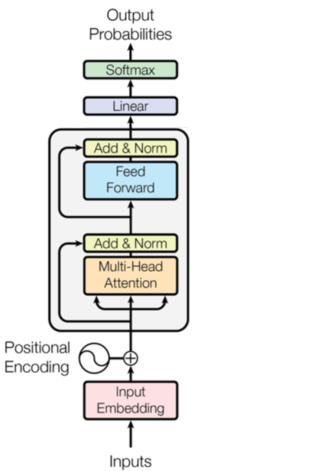

In [6]:
class TransformerBlock(tfkl.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        # Multi-head self-attention layer
        self.att = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # Feed-forward layer
        self.ffn = tfk.Sequential(
            [
                tfkl.Dense(ff_dim, activation="relu"), 
                tfkl.Dense(embed_dim)
            ]
        )
        # Layer normalization for the attention output
        self.layernorm1 = tfkl.LayerNormalization(epsilon=1e-6)
        # Layer normalization for the feed-forward output
        self.layernorm2 = tfkl.LayerNormalization(epsilon=1e-6)
        # Dropout layer for the attention output
        self.dropout1 = tfkl.Dropout(rate)
        # Dropout layer for the feed-forward output
        self.dropout2 = tfkl.Dropout(rate)

    def call(self, inputs, training):
        # Self-attention
        attn_output = self.att(inputs, inputs)
        # Apply dropout to the attention output
        attn_output = self.dropout1(attn_output, training=training)
        # Add the attention output to the input and normalize
        out1 = self.layernorm1(inputs + attn_output)
        # Feed-forward
        ffn_output = self.ffn(out1)
        # Apply dropout to the feed-forward output
        ffn_output = self.dropout2(ffn_output, training=training)
        # Add the feed-forward output to the previous output and normalize
        return self.layernorm2(out1 + ffn_output)

The IMDB dataset is a collection of movie reviews from the Internet Movie Database (IMDB) website. It includes reviews, ratings, and other information for a large number of movies. The dataset is a common benchmark for natural language processing and machine learning research, particularly for sentiment analysis and text classification tasks. The dataset is preprocessed, where the reviews are already labeled as positive or negative.

In [7]:
class TokenAndPositionEmbedding(tfkl.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super(**kwargs).__init__(**kwargs)
        # Embedding layer for the token
        self.token_emb = tfkl.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        # Embedding layer for the position
        self.pos_emb = tfkl.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        # Find the maximum length of the input
        maxlen = tf.shape(x)[-1]
        # Create a tensor with positions from 0 to maxlen-1
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # Embed the positions
        positions = self.pos_emb(positions)
        # Embed the tokens
        x = self.token_emb(x)
        # Add the token and position embeddings
        return x + positions

In [8]:
# Set the vocabulary size and maximum length of each sequence
vocab_size = 20000
maxlen = 400

# Load the IMDB dataset from TensorFlow Keras, using the specified vocabulary size
(x_train, y_train), (x_val, y_val) = tfk.datasets.imdb.load_data(num_words=vocab_size)

# Print the number of training and validation sequences
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")

# Pad sequences in the training and validation sets to have a length of 400
x_train = tfk.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = tfk.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

17464789/17464789 [==============================] - 0s 0us/step
25000 Training sequences
25000 Validation sequences


In [9]:
def create_model(maxlen, vocab_size, embed_dim, num_heads, ff_dim):
    """
    This function creates a transformer-based model for text classification. 
    It takes in several parameters that determine the shape of the model:

        maxlen: the maximum length of the input sequences
        vocab_size: the size of the vocabulary
        embed_dim: the dimension of the token and position embeddings
        num_heads: the number of heads in the multi-head attention
        ff_dim: the dimension of the feed-forward layers
    
    It creates an input layer of shape (maxlen,), instantiates the TokenAndPositionEmbedding
    and TransformerBlock layers, applies the token and position embeddings to the input, 
    and applies the transformer block to the output of the embedding layer.
    Then it applies global average pooling, dropout, dense layers with relu activation and
    dropout again, and finally a dense layer with softmax activation. 
    This last layer is the output layer of the model, which will return the probability of each class.
    Finally, the function creates a Keras model using the input and output layers and returns it.
    """
    # Define the input layer
    inputs = tfkl.Input(shape=(maxlen,))
    
    # Instantiate the TokenAndPositionEmbedding layer
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    
    # Apply the embedding layer to the input
    x = embedding_layer(inputs)
    
    # Instantiate the TransformerBlock layer
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    
    # Apply the transformer block to the output of the embedding layer
    x = transformer_block(x)
    
    # Apply global average pooling
    x = tfkl.GlobalAveragePooling1D()(x)
    # Apply dropout
    x = tfkl.Dropout(0.5)(x)
    # Add a dense layer with softmax activation
    outputs = tfkl.Dense(2, activation="softmax")(x)

    # Create a model using the input and output layers
    model = tfk.Model(inputs=inputs, outputs=outputs, name='Transformer')
    return model

In [10]:
# Embedding size for each token
embed_dim = 128
# Number of attention heads
num_heads = 4 
# Hidden layer size in feed forward network inside transformer
ff_dim = 128  

# Create the transformer model with specified parameters
transformer = create_model(maxlen, vocab_size, embed_dim, num_heads, ff_dim)
transformer.summary()

Model: "Transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400)]             0         
                                                                 
 token_and_position_embeddin  (None, 400, 128)         2611200   
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 400, 128)         297344    
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 128)               

In [11]:
learning_rate = 1e-4
optimizer = tfk.optimizers.Adam(learning_rate)
loss = tfk.losses.SparseCategoricalCrossentropy()
metrics = ["accuracy"]

transformer.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
EPOCHS = 50
BATCH_SIZE = 128

history = transformer.fit(
    x_train, 
    y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_data=(x_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
    ]
)

Epoch 1/50
196/196 [==============================] - 1597s 8s/step - loss: 0.6798 - accuracy: 0.5852 - val_loss: 0.5987 - val_accuracy: 0.7466
Epoch 2/50
196/196 [==============================] - 1582s 8s/step - loss: 0.4501 - accuracy: 0.8033 - val_loss: 0.3375 - val_accuracy: 0.8571
Epoch 3/50
 71/196 [=========>....................] - ETA: 12:24 - loss: 0.2781 - accuracy: 0.8906

In [ ]:
best_epoch = np.argmax(history.history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history.history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history.history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Sparse Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history.history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history.history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
transformer.save('TransformerEncoderClassifier')

In [ ]:
temp = tfk.models.load_model('TransformerEncoderClassifier')
predictions = temp.predict(x_val, verbose=0).T[1]

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_val, np.round(predictions).astype(int))

# Compute the classification metrics
accuracy = accuracy_score(y_val, np.round(predictions).astype(int))
precision = precision_score(y_val, np.round(predictions).astype(int))
recall = recall_score(y_val, np.round(predictions).astype(int))
f1 = f1_score(y_val, np.round(predictions).astype(int))
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm.T, cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()